In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
import os
import numpy as np
import matplotlib.cm as cm

In [2]:
warnings.filterwarnings('ignore')

In [3]:
output_dir = 'kmeans_plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created output directory: {output_dir}")

Created output directory: kmeans_plots


In [4]:
df = pd.read_csv('/kaggle/input/customer-segementation/Mall_Customers.csv')

In [5]:
print(df.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
# Drop CustomerID as it's not relevant for clustering
df_processed = df.drop('CustomerID', axis=1)

In [8]:
# Encode 'Gender' column
le = LabelEncoder()
df_processed['Gender_encoded'] = le.fit_transform(df_processed['Gender'])
gender_mapping = {0: 'Female', 1: 'Male'}
df_processed['Gender_decoded'] = df_processed['Gender_encoded'].map(gender_mapping)

In [9]:
print(df_processed.head())

   Gender  Age  Annual Income (k$)  Spending Score (1-100)  Gender_encoded  \
0    Male   19                  15                      39               1   
1    Male   21                  15                      81               1   
2  Female   20                  16                       6               0   
3  Female   23                  16                      77               0   
4  Female   31                  17                      40               0   

  Gender_decoded  
0           Male  
1           Male  
2         Female  
3         Female  
4         Female  


In [10]:
# Prepare data for clustering (using Annual Income and Spending Score)
X_income_spending = df_processed[['Annual Income (k$)', 'Spending Score (1-100)']]
scaler_income_spending = StandardScaler()
X_scaled_income_spending = scaler_income_spending.fit_transform(X_income_spending)

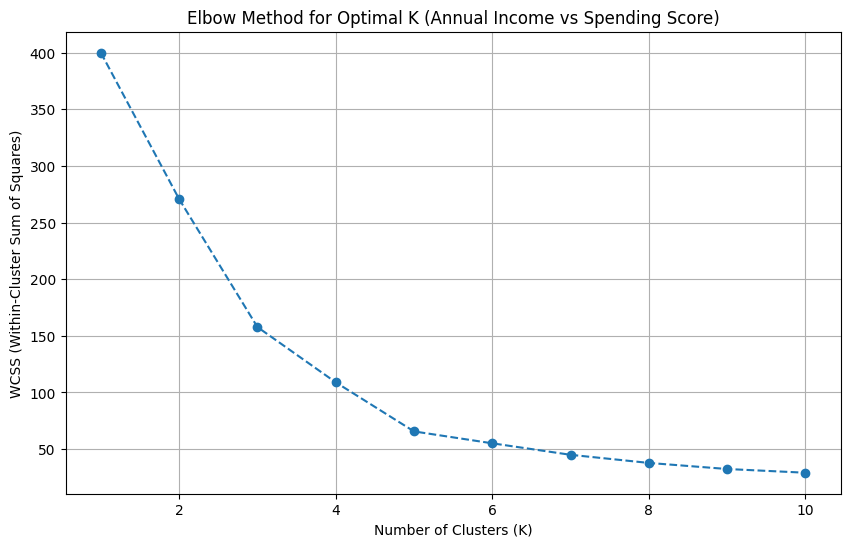

In [11]:
# 1. Elbow Method to find Optimal K (using Annual Income and Spending Score)
wcss = [] 
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled_income_spending)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K (Annual Income vs Spending Score)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'elbow_method_income_spending.png'))
plt.show()
plt.close()

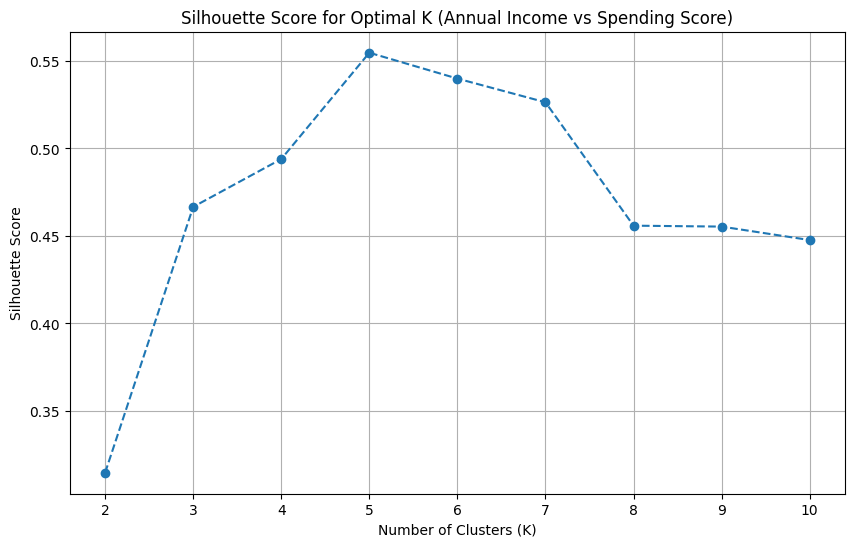

In [12]:
# 2. Silhouette Score Method to find Optimal K (using Annual Income and Spending Score)
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled_income_spending)
    score = silhouette_score(X_scaled_income_spending, cluster_labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal K (Annual Income vs Spending Score)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'silhouette_score_income_spending.png'))
plt.show()
plt.close()

In [13]:
optimal_k = 5

In [14]:
# Visualization 1: Annual Income vs Spending Score

kmeans_income_spending = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
df_processed['Cluster_Income_Spending'] = kmeans_income_spending.fit_predict(X_scaled_income_spending)

In [15]:
# Get centroids and inverse transform them
centroids_income_spending_scaled = kmeans_income_spending.cluster_centers_
centroids_income_spending = scaler_income_spending.inverse_transform(centroids_income_spending_scaled)

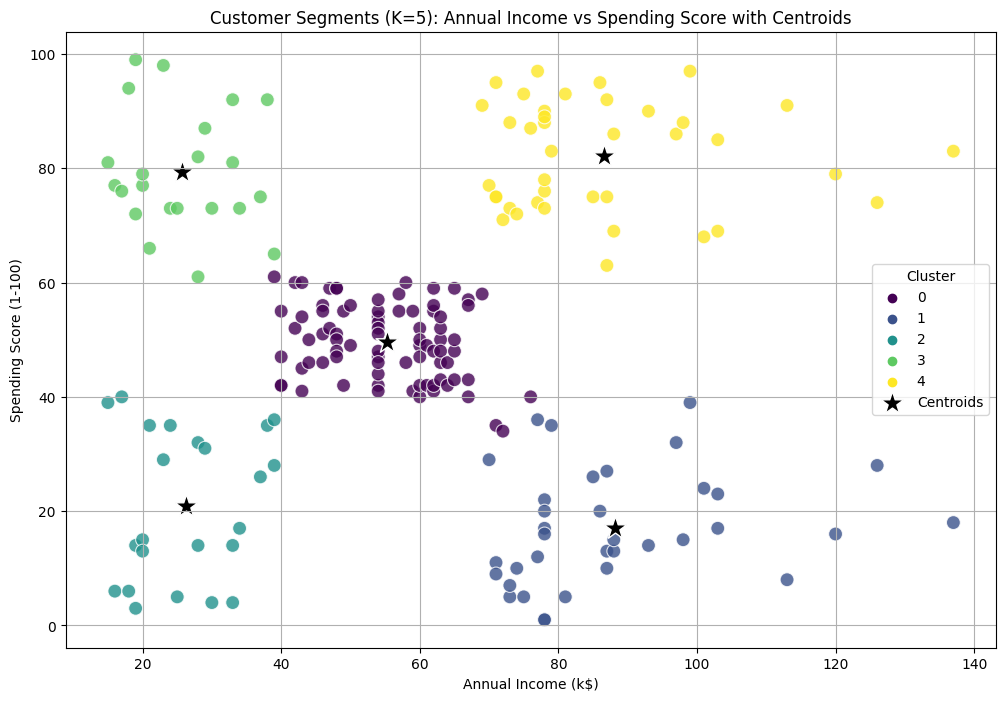

In [16]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster_Income_Spending',
                data=df_processed, palette='viridis', s=100, alpha=0.8, legend='full')
plt.scatter(centroids_income_spending[:, 0], centroids_income_spending[:, 1],
            marker='*', s=300, c='black', edgecolors='white', label='Centroids')
plt.title(f'Customer Segments (K={optimal_k}): Annual Income vs Spending Score with Centroids')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'cluster_income_spending.png'))
plt.show()
plt.close()

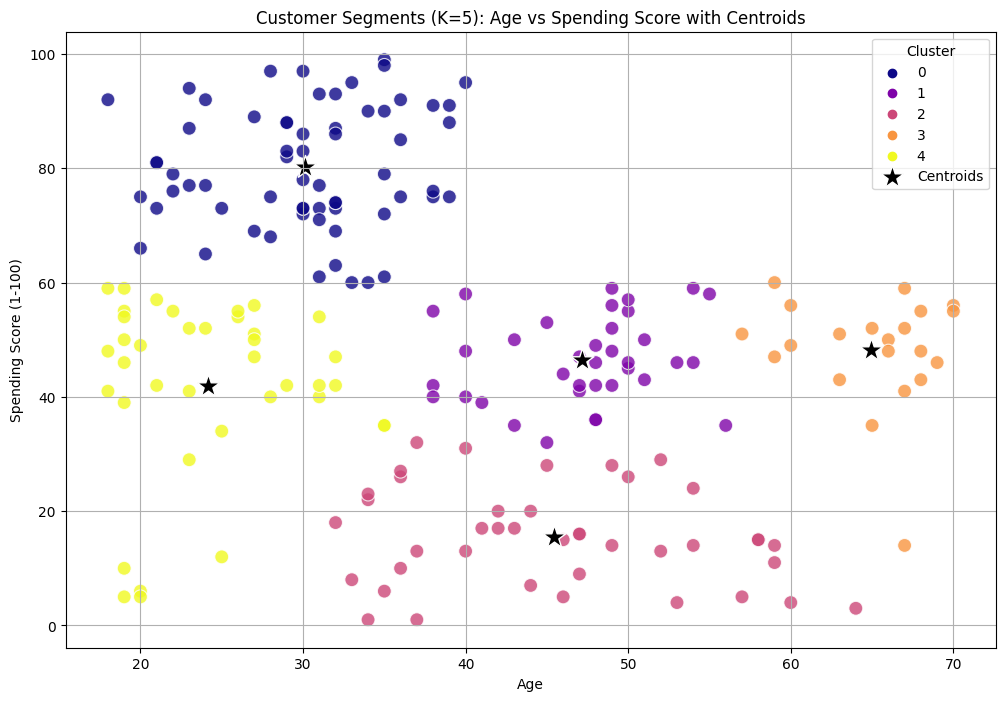

In [17]:
# Visualization 2: Age vs Spending Score
X_age_spending = df_processed[['Age', 'Spending Score (1-100)']]
scaler_age_spending = StandardScaler()
X_scaled_age_spending = scaler_age_spending.fit_transform(X_age_spending)

kmeans_age_spending = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
df_processed['Cluster_Age_Spending'] = kmeans_age_spending.fit_predict(X_scaled_age_spending)

# Get centroids and inverse transform them
centroids_age_spending_scaled = kmeans_age_spending.cluster_centers_
centroids_age_spending = scaler_age_spending.inverse_transform(centroids_age_spending_scaled)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='Age', y='Spending Score (1-100)', hue='Cluster_Age_Spending',
                data=df_processed, palette='plasma', s=100, alpha=0.8, legend='full')
plt.scatter(centroids_age_spending[:, 0], centroids_age_spending[:, 1],
            marker='*', s=300, c='black', edgecolors='white', label='Centroids')
plt.title(f'Customer Segments (K={optimal_k}): Age vs Spending Score with Centroids')
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'cluster_age_spending.png'))
plt.show()
plt.close()


--- Clustering: Gender vs Spending Score ---


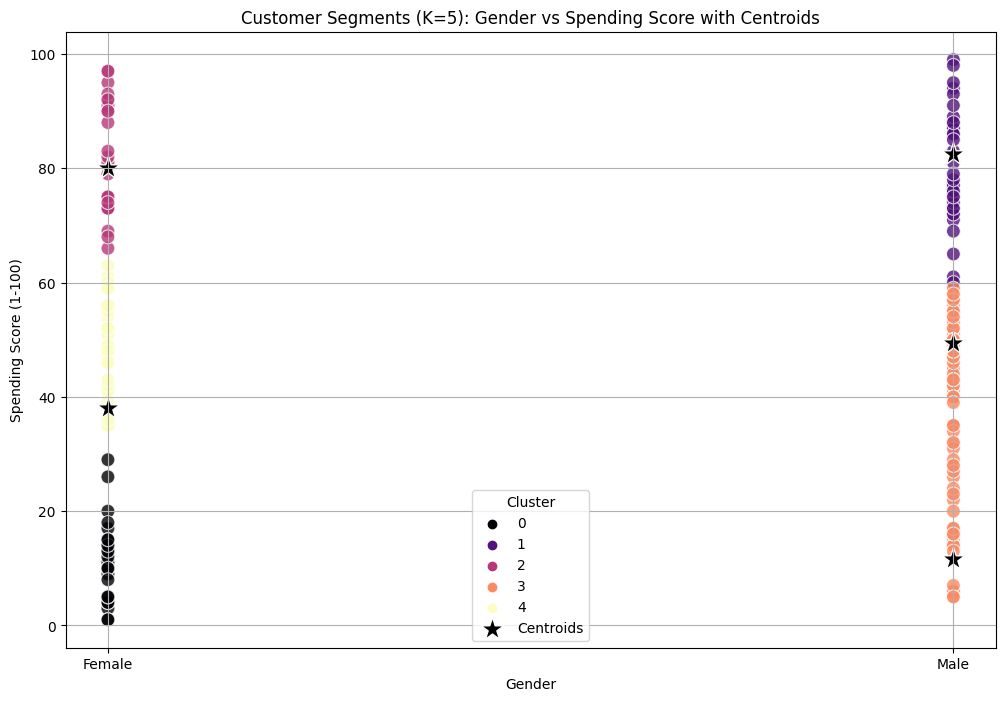

In [18]:
# Visualization 3: Gender vs Spending Score 
print("\n--- Clustering: Gender vs Spending Score ---")
# For this, we'll cluster on Gender_encoded and Spending Score
X_gender_spending = df_processed[['Gender_encoded', 'Spending Score (1-100)']]
scaler_gender_spending = StandardScaler()
X_scaled_gender_spending = scaler_gender_spending.fit_transform(X_gender_spending)

kmeans_gender_spending = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
df_processed['Cluster_Gender_Spending'] = kmeans_gender_spending.fit_predict(X_scaled_gender_spending)

# Get centroids and inverse transform them
centroids_gender_spending_scaled = kmeans_gender_spending.cluster_centers_
centroids_gender_spending = scaler_gender_spending.inverse_transform(centroids_gender_spending_scaled)

centroid_gender_labels = [gender_mapping[round(g)] if round(g) in gender_mapping else 'Mixed' for g in centroids_gender_spending[:, 0]]


plt.figure(figsize=(12, 8))
sns.scatterplot(x='Gender', y='Spending Score (1-100)', hue='Cluster_Gender_Spending',
                data=df_processed, palette='magma', s=100, alpha=0.8, legend='full')


# Get the unique gender labels for the x-axis
unique_genders = df_processed['Gender'].unique()
gender_x_positions = [le.transform([g])[0] for g in unique_genders] # Get numerical positions

# Plot centroids by mapping their numerical gender value to the categorical x-axis
plt.scatter(centroids_gender_spending[:, 0], centroids_gender_spending[:, 1],
            marker='*', s=300, c='black', edgecolors='white', label='Centroids')

# Set x-axis ticks to represent 'Female' and 'Male'
plt.xticks([0, 1], ['Female', 'Male'])

plt.title(f'Customer Segments (K={optimal_k}): Gender vs Spending Score with Centroids')
plt.xlabel('Gender')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'cluster_gender_spending_scatterplot.png'))
plt.show()
plt.close()

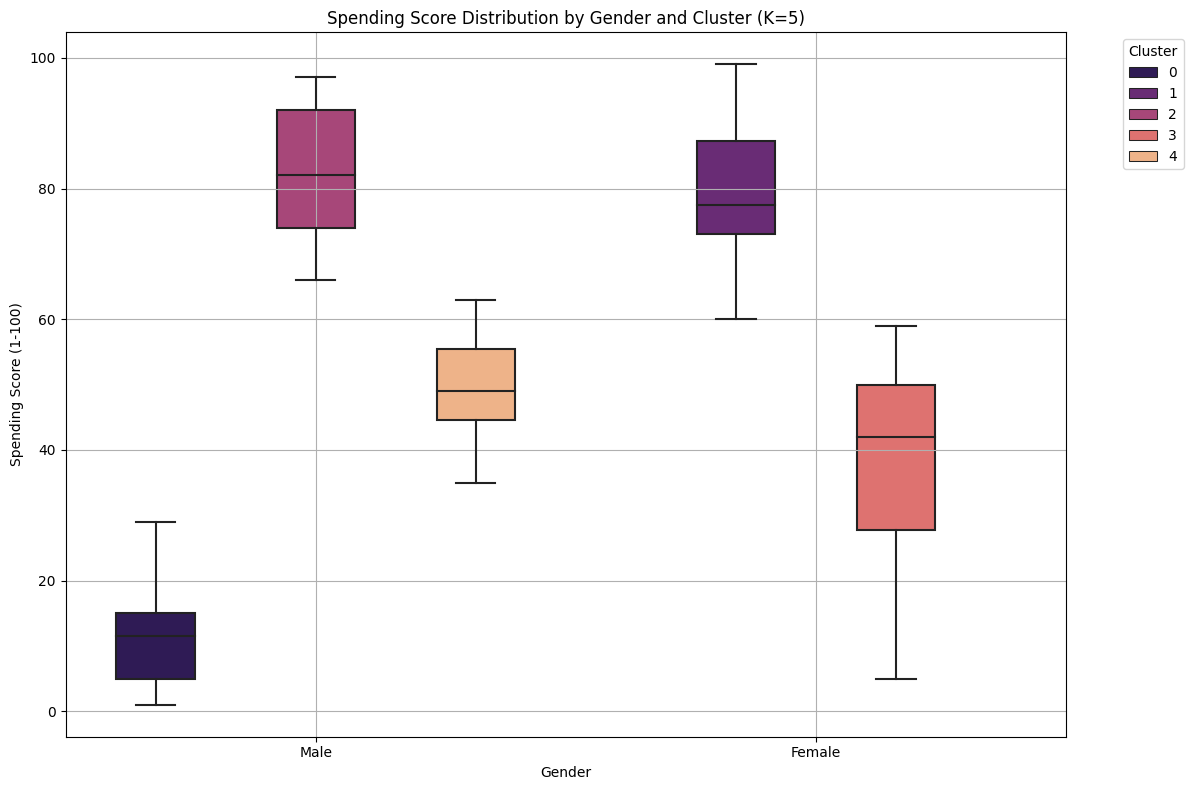

In [19]:
# A box plot can be insightful for categorical vs numerical
plt.figure(figsize=(12, 8))
sns.boxplot(x='Gender', y='Spending Score (1-100)', hue='Cluster_Gender_Spending',
            data=df_processed, palette='magma')
plt.title(f'Spending Score Distribution by Gender and Cluster (K={optimal_k})')
plt.xlabel('Gender')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'cluster_gender_spending_boxplot.png'))
plt.show()
plt.close()

In [20]:
# Visualization 4: (Annual Income, Age, Gender) vs Spending Score 
print("\n--- Clustering: (Annual Income, Age, Gender) vs Spending Score ---")
# Features for clustering
X_multi_dim = df_processed[['Annual Income (k$)', 'Age', 'Gender_encoded', 'Spending Score (1-100)']]
scaler_multi_dim = StandardScaler()
X_scaled_multi_dim = scaler_multi_dim.fit_transform(X_multi_dim)

# Apply K-means
kmeans_multi_dim = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
df_processed['Cluster_Multi_Dim'] = kmeans_multi_dim.fit_predict(X_scaled_multi_dim)

# Get centroids in scaled multi-dimensional space
centroids_multi_dim_scaled = kmeans_multi_dim.cluster_centers_

# Use PCA for dimensionality reduction to visualize 4D data in 2D
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled_multi_dim)
df_pca = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
df_pca['Cluster_Multi_Dim'] = df_processed['Cluster_Multi_Dim']

# Transform centroids using the *same* PCA model
centroids_multi_dim_pca = pca.transform(centroids_multi_dim_scaled)


--- Clustering: (Annual Income, Age, Gender) vs Spending Score ---


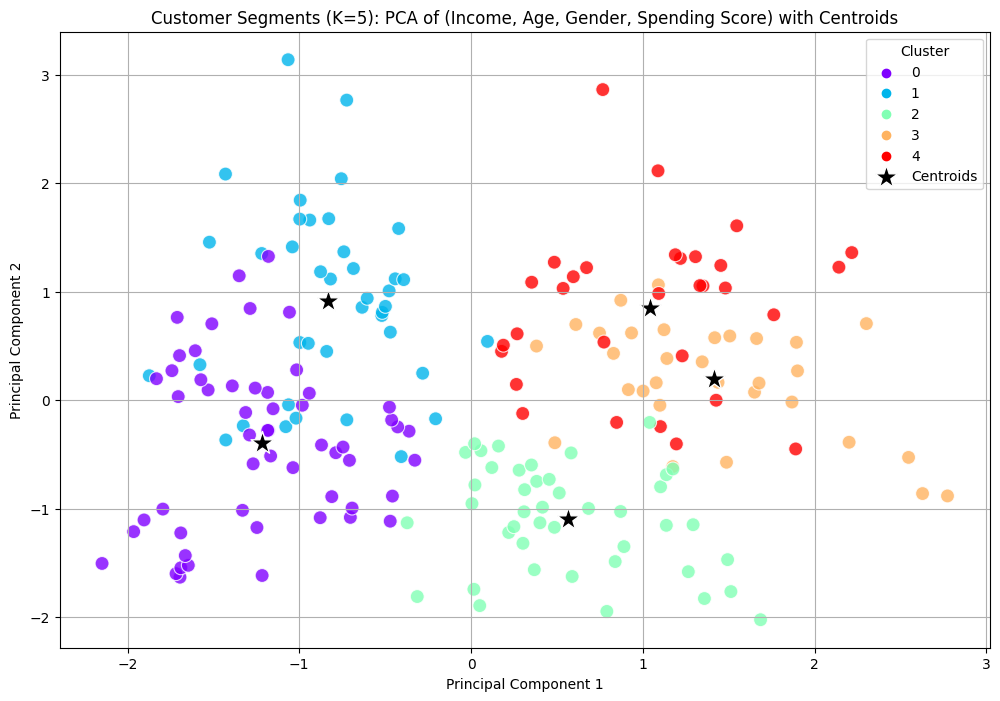

In [21]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Cluster_Multi_Dim',
                data=df_pca, palette='rainbow', s=100, alpha=0.8, legend='full')
plt.scatter(centroids_multi_dim_pca[:, 0], centroids_multi_dim_pca[:, 1],
            marker='*', s=300, c='black', edgecolors='white', label='Centroids')
plt.title(f'Customer Segments (K={optimal_k}): PCA of (Income, Age, Gender, Spending Score) with Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'cluster_multi_dim_pca.png'))
plt.show()
plt.close()

In [22]:
processed_csv_path = os.path.join(output_dir, 'Mall_Customers_Processed_with_Clusters.csv')
df_processed.to_csv(processed_csv_path, index=False)
processed_csv_path

'kmeans_plots/Mall_Customers_Processed_with_Clusters.csv'

In [23]:
# Cluster Naming Aid: Print Mean Values for Each Cluster 
print("\n--- Cluster Characteristics (Mean Values for Each Cluster) ---")

# For Cluster_Income_Spending
print("\nCluster Characteristics for 'Annual Income vs Spending Score' (Cluster_Income_Spending):")
cluster_income_spending_means = df_processed.groupby('Cluster_Income_Spending')[['Annual Income (k$)', 'Spending Score (1-100)']].mean()
print(cluster_income_spending_means)

# For Cluster_Age_Spending
print("\nCluster Characteristics for 'Age vs Spending Score' (Cluster_Age_Spending):")
cluster_age_spending_means = df_processed.groupby('Cluster_Age_Spending')[['Age', 'Spending Score (1-100)']].mean()
print(cluster_age_spending_means)

# For Cluster_Gender_Spending
print("\nCluster Characteristics for 'Gender vs Spending Score' (Cluster_Gender_Spending):")
# Include original Gender to see distribution if needed, or Gender_encoded mean
cluster_gender_spending_means = df_processed.groupby('Cluster_Gender_Spending')[['Gender_encoded', 'Spending Score (1-100)']].mean()
print(cluster_gender_spending_means)

# For Cluster_Multi_Dim
print("\nCluster Characteristics for '(Annual Income, Age, Gender) vs Spending Score' (Cluster_Multi_Dim):")
cluster_multi_dim_means = df_processed.groupby('Cluster_Multi_Dim')[['Annual Income (k$)', 'Age', 'Gender_encoded', 'Spending Score (1-100)']].mean()
print(cluster_multi_dim_means)


--- Cluster Characteristics (Mean Values for Each Cluster) ---

Cluster Characteristics for 'Annual Income vs Spending Score' (Cluster_Income_Spending):
                         Annual Income (k$)  Spending Score (1-100)
Cluster_Income_Spending                                            
0                                 55.296296               49.518519
1                                 88.200000               17.114286
2                                 26.304348               20.913043
3                                 25.727273               79.363636
4                                 86.538462               82.128205

Cluster Characteristics for 'Age vs Spending Score' (Cluster_Age_Spending):
                            Age  Spending Score (1-100)
Cluster_Age_Spending                                   
0                     30.140625               80.156250
1                     47.138889               46.444444
2                     45.439024               15.536585
3            